## Analysis Goal

This dataset encompasses readings from a metal oxide multisensor array, commercial temperature and humidity sensors, alongside ground truth measurements of pollutants: CO, NMHC, C6H6, NOx, and NO2. Our aim is to identify a regression algorithm that calibrates sensor array signals to precisely predict pollutant concentrations, optimizing for minimal training time and prolonged stable operation.

In this analysis, we commence with data cleaning and exploratory data analysis (EDA), followed by simple linear regression to set a baseline. Subsequently, we explore neural networks (as discussed in the original paper) and random forest regressor to ascertain the optimal complexity for this task. Interestingly, linear regression emerged as the most effective, closely followed by tree-based methods, with neural networks trailing.

## Data loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# # Local
# root = ''

# Kaggle
root = '../input/air-quality-data-set/'

df = pd.read_csv(root + 'AirQuality.csv', sep=';', decimal=',')
df

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1     10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2     10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3     10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4     10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   
...          ...       ...     ...          ...       ...       ...   
9466         NaN       NaN     NaN          NaN       NaN       NaN   
9467         NaN       NaN     NaN          NaN       NaN       NaN   
9468         NaN       NaN     NaN          NaN       NaN       NaN   
9469         NaN       NaN     NaN          NaN       NaN       NaN   
9470         NaN       NaN     NaN          NaN       NaN       NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0            1046.0    166.0        1056.0    113.0        1692.0   
1             955.0    103.0        1174.0     92.0        1559.0   
2             939.0    131.0        1140.0    114.0        1555.0   
3             948.0    172.0        1092.0    122.0        1584.0   
4             836.0    131.0        1205.0    116.0        1490.0   
...             ...      ...           ...      ...           ...   
9466            NaN      NaN           NaN      NaN           NaN   
9467            NaN      NaN           NaN      NaN           NaN   
9468            NaN      NaN           NaN      NaN           NaN   
9469            NaN      NaN           NaN      NaN           NaN   
9470            NaN      NaN           NaN      NaN           NaN   

      PT08.S5(O3)     T    RH      AH  Unnamed: 15  Unnamed: 16  
0          1268.0  13.6  48.9  0.7578          NaN          NaN  
1           972.0  13.3  47.7  0.7255          NaN          NaN  
2          1074.0  11.9  54.0  0.7502          NaN          NaN  
3          1203.0  11.0  60.0  0.7867          NaN          NaN  
4          1110.0  11.2  59.6  0.7888          NaN          NaN  
...           ...   ...   ...     ...          ...          ...  
9466          NaN   NaN   NaN     NaN          NaN          NaN  
9467          NaN   NaN   NaN     NaN          NaN          NaN  
9468          NaN   NaN   NaN     NaN          NaN          NaN  
9469          NaN   NaN   NaN     NaN          NaN          NaN  
9470          NaN   NaN   NaN     NaN          NaN          NaN  

[9471 rows x 17 columns]

## Data Cleaning

The last two columns can be safely removed as they are all nulls, and all null values in other columns are all in the end of the dataframe, so we can safely remove them through simple operations.

In [2]:
# Look at null values
df.isnull().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [3]:
df.tail(116)

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
9355  04/04/2005  13.00.00     2.1       1003.0    -200.0       9.5   
9356  04/04/2005  14.00.00     2.2       1071.0    -200.0      11.9   
9357         NaN       NaN     NaN          NaN       NaN       NaN   
9358         NaN       NaN     NaN          NaN       NaN       NaN   
9359         NaN       NaN     NaN          NaN       NaN       NaN   
...          ...       ...     ...          ...       ...       ...   
9466         NaN       NaN     NaN          NaN       NaN       NaN   
9467         NaN       NaN     NaN          NaN       NaN       NaN   
9468         NaN       NaN     NaN          NaN       NaN       NaN   
9469         NaN       NaN     NaN          NaN       NaN       NaN   
9470         NaN       NaN     NaN          NaN       NaN       NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
9355          961.0    235.0         702.0    156.0        1041.0   
9356         1047.0    265.0         654.0    168.0        1129.0   
9357            NaN      NaN           NaN      NaN           NaN   
9358            NaN      NaN           NaN      NaN           NaN   
9359            NaN      NaN           NaN      NaN           NaN   
...             ...      ...           ...      ...           ...   
9466            NaN      NaN           NaN      NaN           NaN   
9467            NaN      NaN           NaN      NaN           NaN   
9468            NaN      NaN           NaN      NaN           NaN   
9469            NaN      NaN           NaN      NaN           NaN   
9470            NaN      NaN           NaN      NaN           NaN   

      PT08.S5(O3)     T    RH      AH  Unnamed: 15  Unnamed: 16  
9355        770.0  28.3  13.5  0.5139          NaN          NaN  
9356        816.0  28.5  13.1  0.5028          NaN          NaN  
9357          NaN   NaN   NaN     NaN          NaN          NaN  
9358          NaN   NaN   NaN     NaN          NaN          NaN  
9359          NaN   NaN   NaN     NaN          NaN          NaN  
...           ...   ...   ...     ...          ...          ...  
9466          NaN   NaN   NaN     NaN          NaN          NaN  
9467          NaN   NaN   NaN     NaN          NaN          NaN  
9468          NaN   NaN   NaN     NaN          NaN          NaN  
9469          NaN   NaN   NaN     NaN          NaN          NaN  
9470          NaN   NaN   NaN     NaN          NaN          NaN  

[116 rows x 17 columns]

In [4]:
# Combine Date and Time to make date time index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', dayfirst = True)
df = df.set_index('Datetime')

# Remove unnecessary columns
df = df.drop(['Date','Time','Unnamed: 15','Unnamed: 16'], axis = 1)

# Remove null values at the end
df = df.dropna()
df

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
Datetime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
...                     ...          ...       ...       ...            ...   
2005-04-04 10:00:00     3.1       1314.0    -200.0      13.5         1101.0   
2005-04-04 11:00:00     2.4       1163.0    -200.0      11.4         1027.0   
2005-04-04 12:00:00     2.4       1142.0    -200.0      12.4         1063.0   
2005-04-04 13:00:00     2.1       1003.0    -200.0       9.5          961.0   
2005-04-04 14:00:00     2.2       1071.0    -200.0      11.9         1047.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
Datetime                                                            
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 19:00:00    103.0        1174.0     92.0        1559.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172.0        1092.0    122.0        1584.0   
2004-03-10 22:00:00    131.0        1205.0    116.0        1490.0   
...                      ...           ...      ...           ...   
2005-04-04 10:00:00    472.0         539.0    190.0        1374.0   
2005-04-04 11:00:00    353.0         604.0    179.0        1264.0   
2005-04-04 12:00:00    293.0         603.0    175.0        1241.0   
2005-04-04 13:00:00    235.0         702.0    156.0        1041.0   
2005-04-04 14:00:00    265.0         654.0    168.0        1129.0   

                     PT08.S5(O3)     T    RH      AH  
Datetime                                              
2004-03-10 18:00:00       1268.0  13.6  48.9  0.7578  
2004-03-10 19:00:00        972.0  13.3  47.7  0.7255  
2004-03-10 20:00:00       1074.0  11.9  54.0  0.7502  
2004-03-10 21:00:00       1203.0  11.0  60.0  0.7867  
2004-03-10 22:00:00       1110.0  11.2  59.6  0.7888  
...                          ...   ...   ...     ...  
2005-04-04 10:00:00       1729.0  21.9  29.3  0.7568  
2005-04-04 11:00:00       1269.0  24.3  23.7  0.7119  
2005-04-04 12:00:00       1092.0  26.9  18.3  0.6406  
2005-04-04 13:00:00        770.0  28.3  13.5  0.5139  
2005-04-04 14:00:00        816.0  28.5  13.1  0.5028  

[9357 rows x 13 columns]

### Removing Bad Sensor Readouts

After the first round of removal, there are still a lot of null values represented by -200. Since they are all within the valid time series, we will replace -200 by NaN and impute them via interpolation.

In [5]:
# impute missing values
import numpy as np
df = df.replace(-200,np.nan)
df.isnull().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [6]:
df = df.interpolate(method='time')
df

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
Datetime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
...                     ...          ...       ...       ...            ...   
2005-04-04 10:00:00     3.1       1314.0     275.0      13.5         1101.0   
2005-04-04 11:00:00     2.4       1163.0     275.0      11.4         1027.0   
2005-04-04 12:00:00     2.4       1142.0     275.0      12.4         1063.0   
2005-04-04 13:00:00     2.1       1003.0     275.0       9.5          961.0   
2005-04-04 14:00:00     2.2       1071.0     275.0      11.9         1047.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
Datetime                                                            
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 19:00:00    103.0        1174.0     92.0        1559.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172.0        1092.0    122.0        1584.0   
2004-03-10 22:00:00    131.0        1205.0    116.0        1490.0   
...                      ...           ...      ...           ...   
2005-04-04 10:00:00    472.0         539.0    190.0        1374.0   
2005-04-04 11:00:00    353.0         604.0    179.0        1264.0   
2005-04-04 12:00:00    293.0         603.0    175.0        1241.0   
2005-04-04 13:00:00    235.0         702.0    156.0        1041.0   
2005-04-04 14:00:00    265.0         654.0    168.0        1129.0   

                     PT08.S5(O3)     T    RH      AH  
Datetime                                              
2004-03-10 18:00:00       1268.0  13.6  48.9  0.7578  
2004-03-10 19:00:00        972.0  13.3  47.7  0.7255  
2004-03-10 20:00:00       1074.0  11.9  54.0  0.7502  
2004-03-10 21:00:00       1203.0  11.0  60.0  0.7867  
2004-03-10 22:00:00       1110.0  11.2  59.6  0.7888  
...                          ...   ...   ...     ...  
2005-04-04 10:00:00       1729.0  21.9  29.3  0.7568  
2005-04-04 11:00:00       1269.0  24.3  23.7  0.7119  
2005-04-04 12:00:00       1092.0  26.9  18.3  0.6406  
2005-04-04 13:00:00        770.0  28.3  13.5  0.5139  
2005-04-04 14:00:00        816.0  28.5  13.1  0.5028  

[9357 rows x 13 columns]

Notice that 'NMHC(GT)' is beyond salvation as it seems broke right after the experiment began. In comparison, other signals are much more reasonable, such as 'CO(GT)'.

<Axes: xlabel='Datetime'>

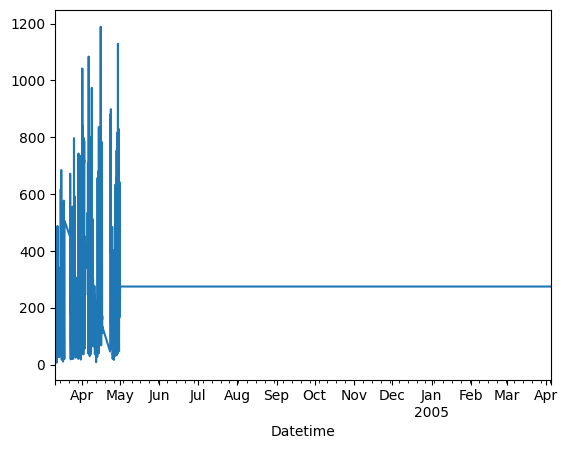

In [7]:
df['NMHC(GT)'].plot()

<Axes: xlabel='Datetime'>

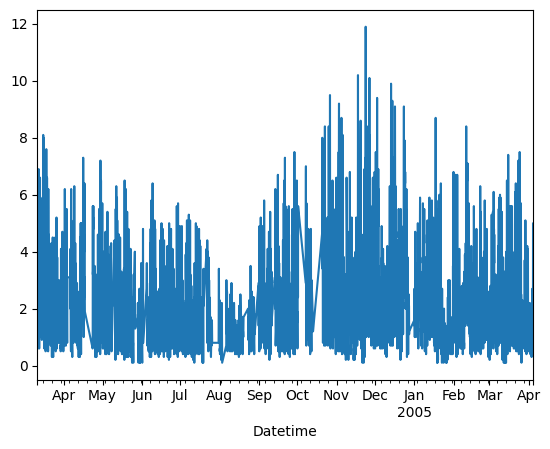

In [8]:
df['CO(GT)'].plot()

## Correlation Matrix

The correlation matrix highlights interrelations among four out of five metal oxide sensors, affirming their cross-sensitivity. These sensors are strong indicators of air quality-related gases, unaffected by temperature and humidity variations.

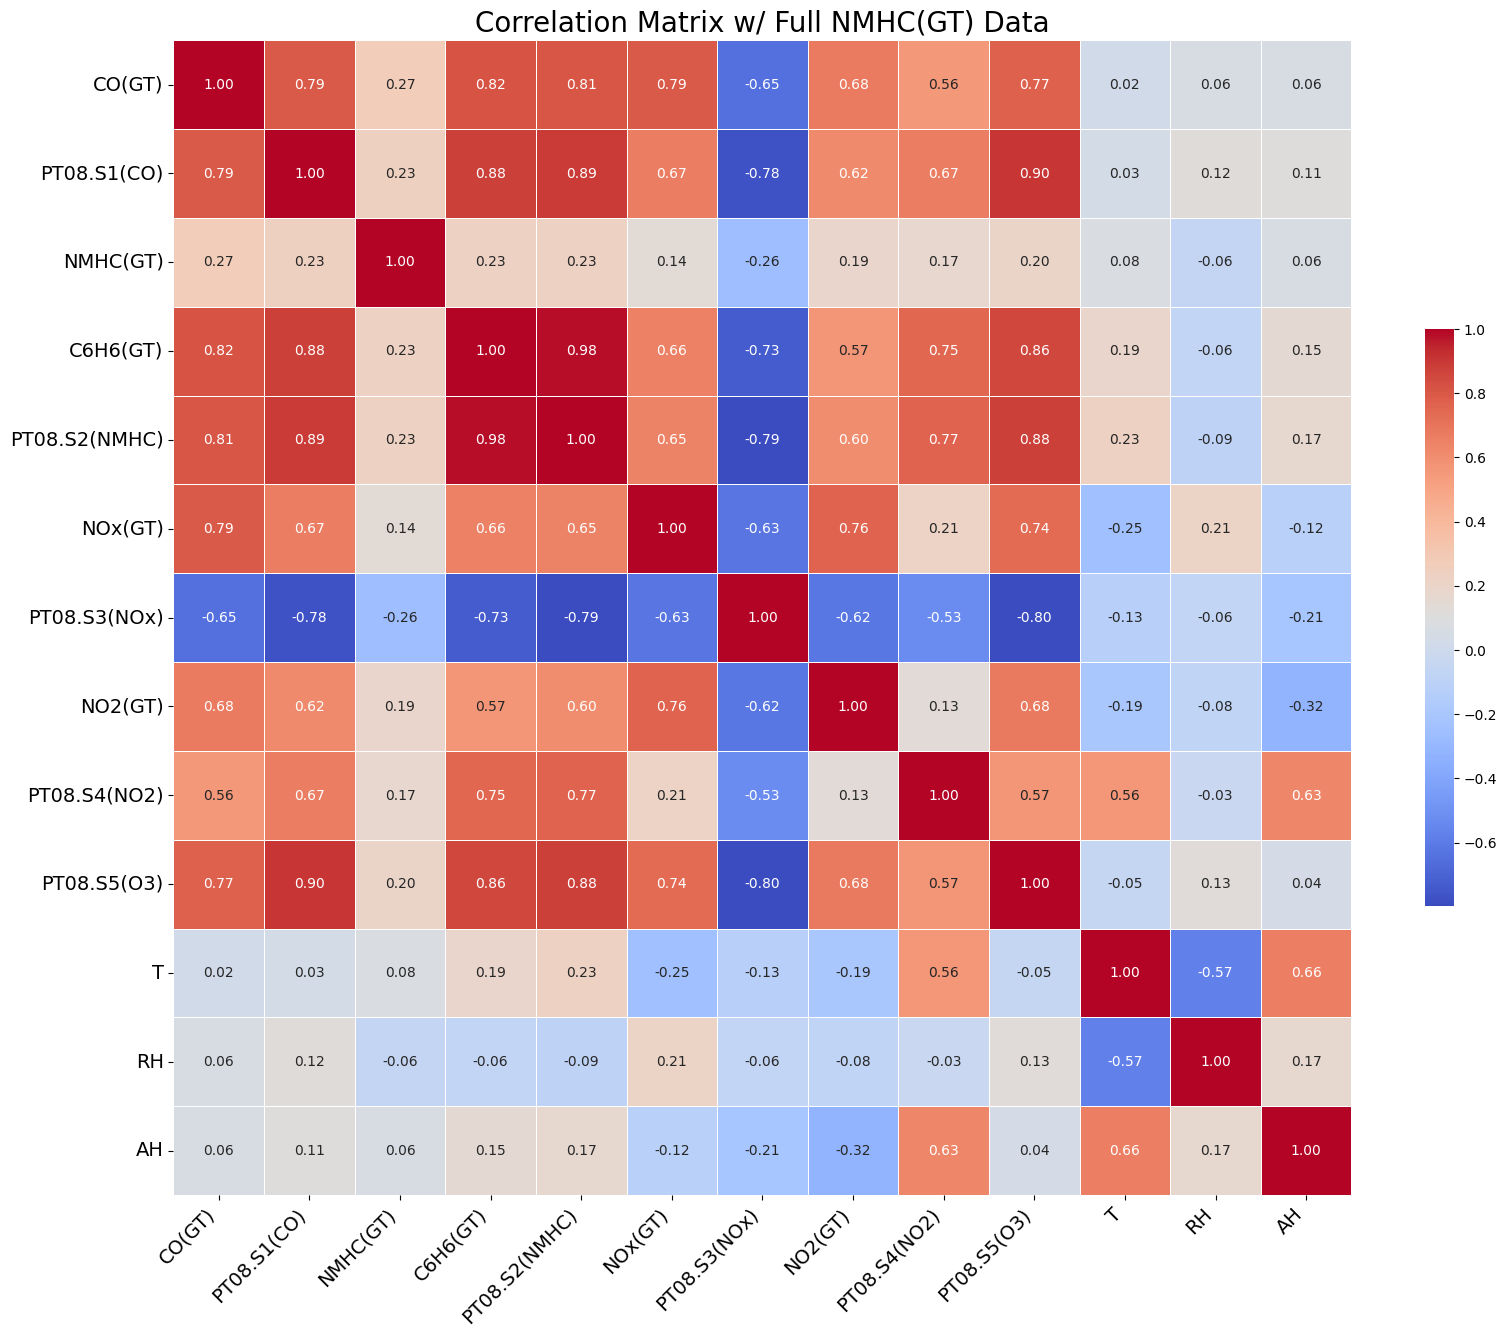

In [9]:
# Calculate the correlation matrix
corr = df.corr()

# Set up the heatmap
f, ax = plt.subplots(figsize=(19, 15))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation Matrix w/ Full NMHC(GT) Data', fontsize=20)
plt.show()

Due to the sparse dataset from the malfunctioning 'NMHC(GT)' analyzer, its correlation with utilized sensors is not significant. However, examining the data prior to the analyzer's malfunction, the correlation matrix presents a different picture. To ensure future model accuracy, we will exclude 'NMHC(GT)' henceforth.

One thing stands out in this matrix is the strong correlation between benzene (C6H6) and sensor 'PT08.S2(NMHC)' with a correlation coefficient of 0.98, making it an easy target for us to go after first.

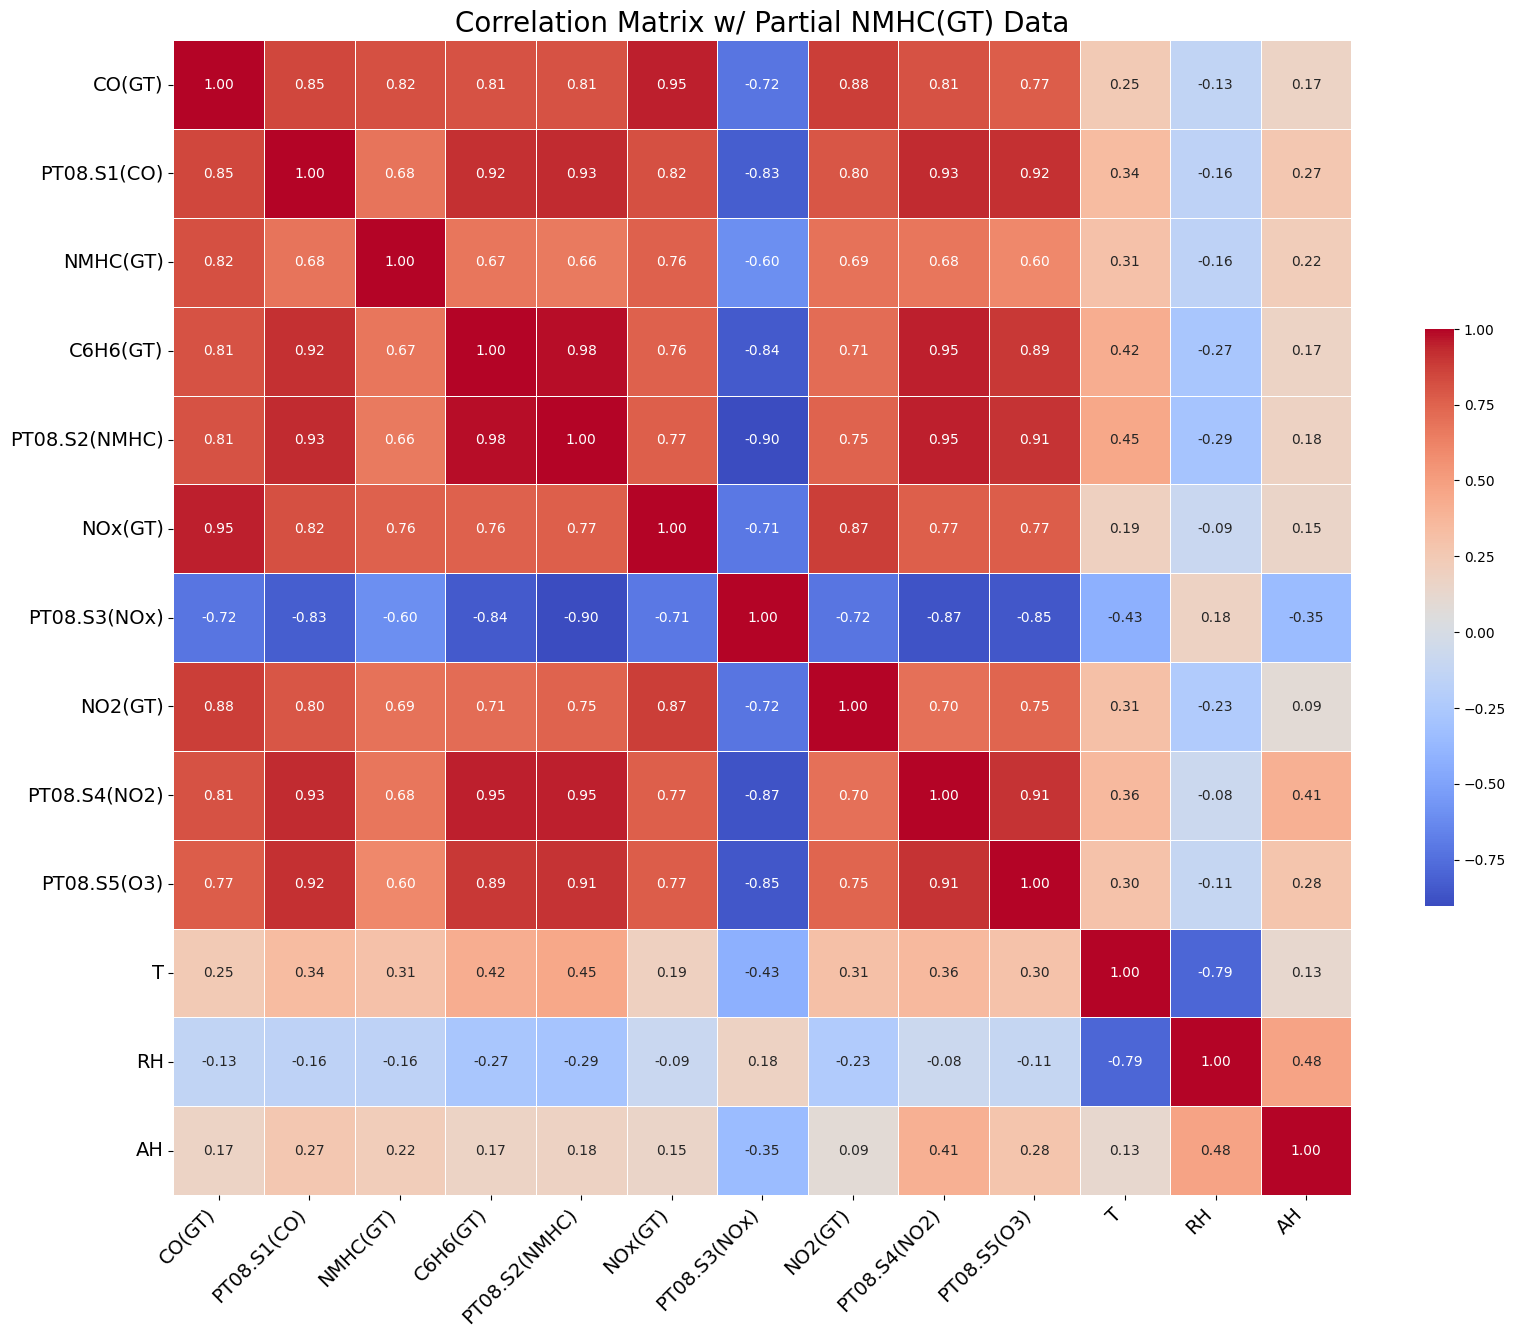

In [10]:
# Calculate the correlation matrix
corr = df[df['NMHC(GT)'] != 275].corr()

f, ax = plt.subplots(figsize=(19, 15))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation Matrix w/ Partial NMHC(GT) Data', fontsize=20)
plt.show()

In [11]:
df = df.drop('NMHC(GT)', axis=1)
df

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
Datetime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   
...                     ...          ...       ...            ...      ...   
2005-04-04 10:00:00     3.1       1314.0      13.5         1101.0    472.0   
2005-04-04 11:00:00     2.4       1163.0      11.4         1027.0    353.0   
2005-04-04 12:00:00     2.4       1142.0      12.4         1063.0    293.0   
2005-04-04 13:00:00     2.1       1003.0       9.5          961.0    235.0   
2005-04-04 14:00:00     2.2       1071.0      11.9         1047.0    265.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Datetime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1555.0       1074.0  11.9   
2004-03-10 21:00:00        1092.0    122.0        1584.0       1203.0  11.0   
2004-03-10 22:00:00        1205.0    116.0        1490.0       1110.0  11.2   
...                           ...      ...           ...          ...   ...   
2005-04-04 10:00:00         539.0    190.0        1374.0       1729.0  21.9   
2005-04-04 11:00:00         604.0    179.0        1264.0       1269.0  24.3   
2005-04-04 12:00:00         603.0    175.0        1241.0       1092.0  26.9   
2005-04-04 13:00:00         702.0    156.0        1041.0        770.0  28.3   
2005-04-04 14:00:00         654.0    168.0        1129.0        816.0  28.5   

                       RH      AH  
Datetime                           
2004-03-10 18:00:00  48.9  0.7578  
2004-03-10 19:00:00  47.7  0.7255  
2004-03-10 20:00:00  54.0  0.7502  
2004-03-10 21:00:00  60.0  0.7867  
2004-03-10 22:00:00  59.6  0.7888  
...                   ...     ...  
2005-04-04 10:00:00  29.3  0.7568  
2005-04-04 11:00:00  23.7  0.7119  
2005-04-04 12:00:00  18.3  0.6406  
2005-04-04 13:00:00  13.5  0.5139  
2005-04-04 14:00:00  13.1  0.5028  

[9357 rows x 12 columns]

## EDA

Weekly averaged data reaffirms matrix observations:

- Four out of five sensors show correlation with NOx and NO2 target analytes.
- 'PT08.S3(NOx)' exhibits a negative correlation with all other sensors and target analytes.

However, the correlation matrix does not capture the sensors' continuously shifting baseline, particularly 'PT08.S4(NO2)'. Additionally, the abrupt NO2 readout increase post-August complicates effective calibration, as will be demonstrated in later sections.

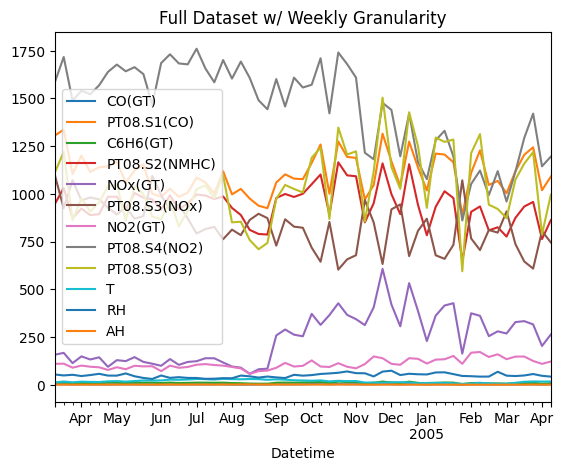

In [12]:
weekly = df.resample('W').mean()
weekly.plot(title = "Full Dataset w/ Weekly Granularity");


### Daily Trends

NOx and NO2 levels peak at the start and end of a typical workday. The sensor array effectively captures these fluctuations.

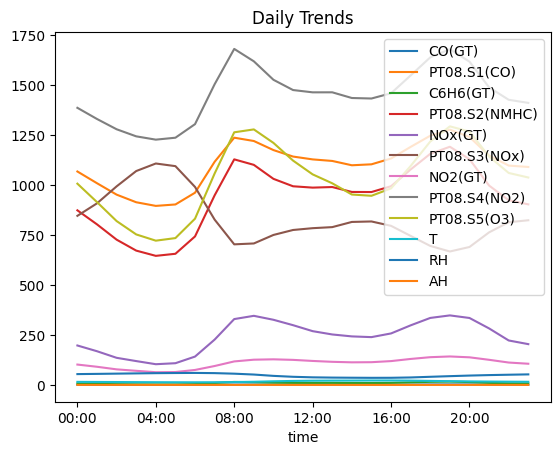

In [13]:
by_time = df.groupby(df.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, title = 'Daily Trends');

## Sensor Calibration w/ Linear Regression

Initially, we apply linear regression using each sensor against all target analytes, training on the dataset's first ten days (~3% of the total dataset) and validating on the remainder. Remarkably, the 'PT08.S2(NMHC)' sensor closely aligns with benzene concentrations, achieving an R-square of 0.96.

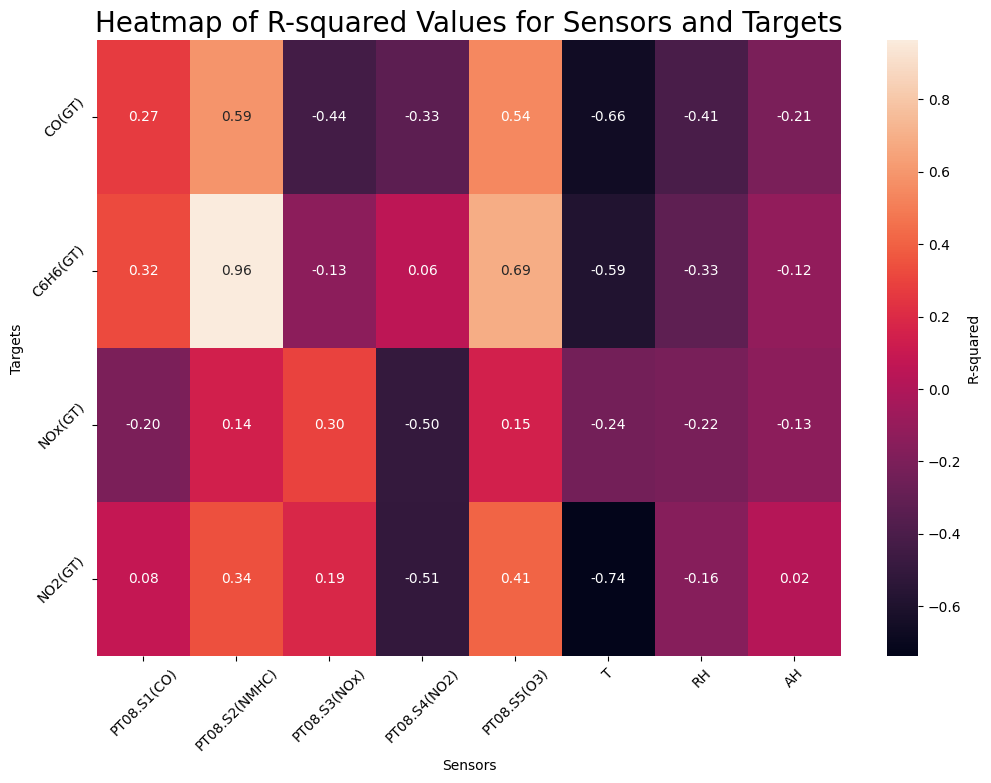

In [14]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define the targets and features
targets = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Define the training period
train_period = '10D'  # 10 days

# Find the date to split the data
split_date = df.index.min() + pd.Timedelta(train_period)

# Initialize a DataFrame to store R-squared values
r2_scores = pd.DataFrame(index=targets, columns=features)

# Loop through each target and sensor
for target in targets:
    # Split the dataset into training and validation sets for the current target
    X_train = df.loc[df.index <= split_date, features]
    y_train = df.loc[df.index <= split_date, target]
    X_test = df.loc[df.index > split_date, features]
    y_test = df.loc[df.index > split_date, target]
    
    for sensor in features:
        # Perform linear regression
        model = LinearRegression()
        model.fit(X_train[[sensor]], y_train)
    
        # Make predictions
        y_pred = model.predict(X_test[[sensor]])
    
        # Calculate R-squared and store it
        r2 = r2_score(y_test, y_pred)
        r2_scores.loc[target, sensor] = r2

# Convert all values in r2_scores to float
r2_scores = r2_scores.astype(float)

# Plot the heatmap of R-squared values
plt.figure(figsize=(12, 8))
sns.heatmap(r2_scores, annot=True, fmt=".2f", cbar_kws={'label': 'R-squared'})
plt.xlabel('Sensors')
plt.ylabel('Targets')
plt.title('Heatmap of R-squared Values for Sensors and Targets', fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Scatter Matrix

The scatter matrix reveals that the strong correlation between 'C6H6' and 'PT08.S2(NMHC)' is unique, with other correlations displaying varying degrees of scatter.

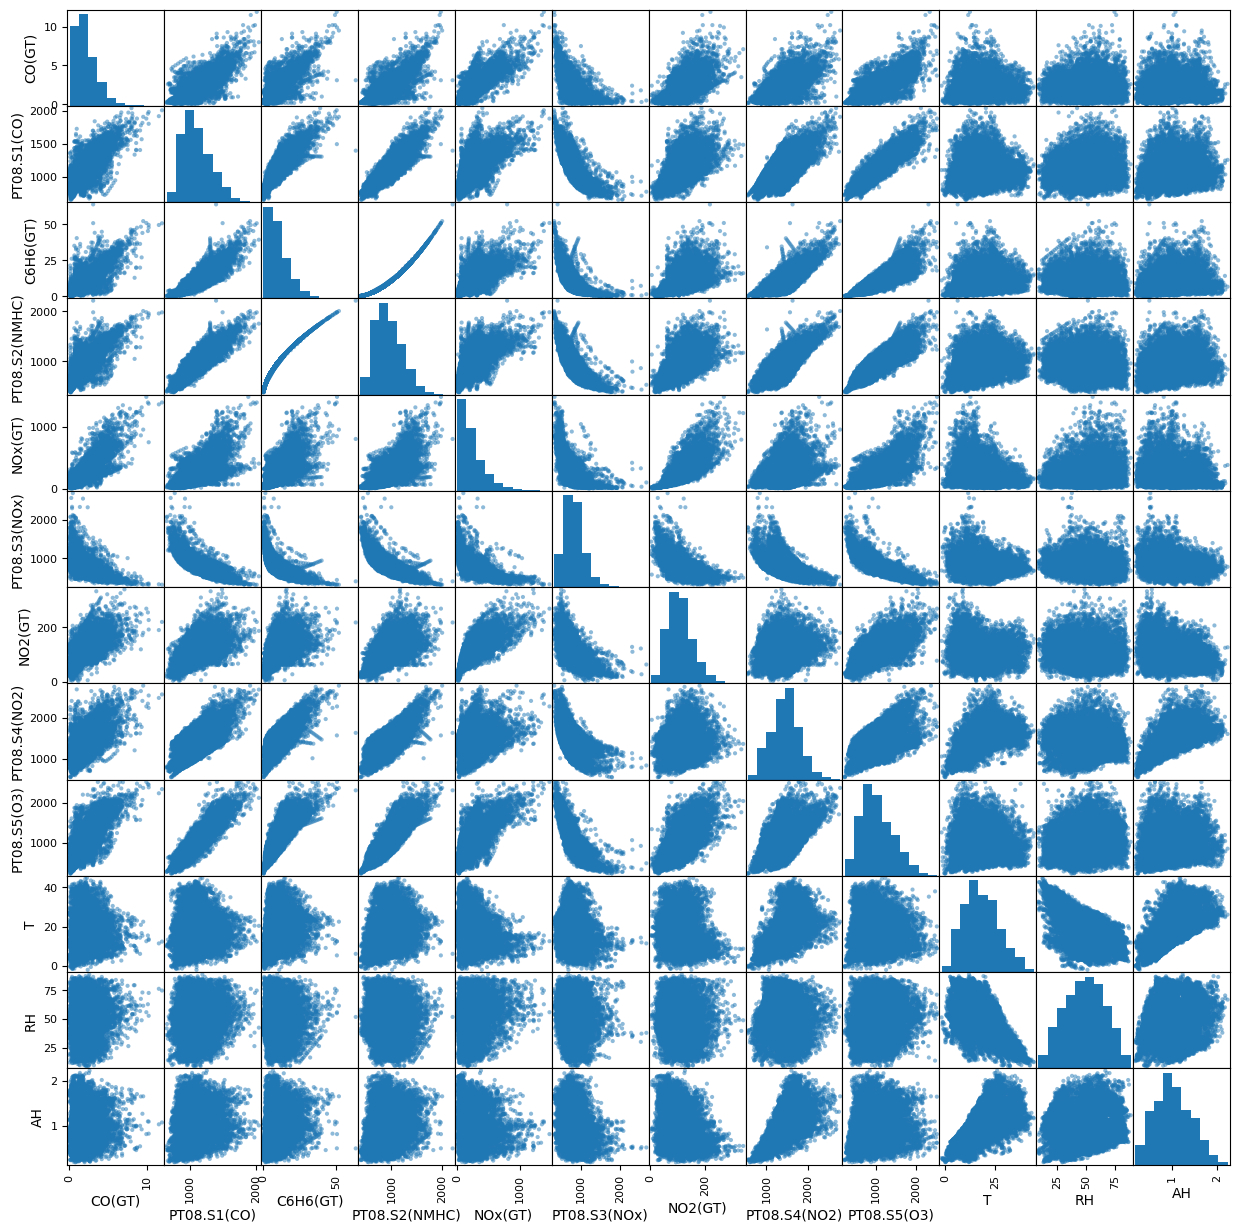

In [15]:
pd.plotting.scatter_matrix(df, figsize=(15,15));

### LR on C6H6 and PT08.S2 sensor

A detailed examination of linear regression results highlights classical underfitting due to the model's limited flexibility. This suggests the potential for a higher-order fit.

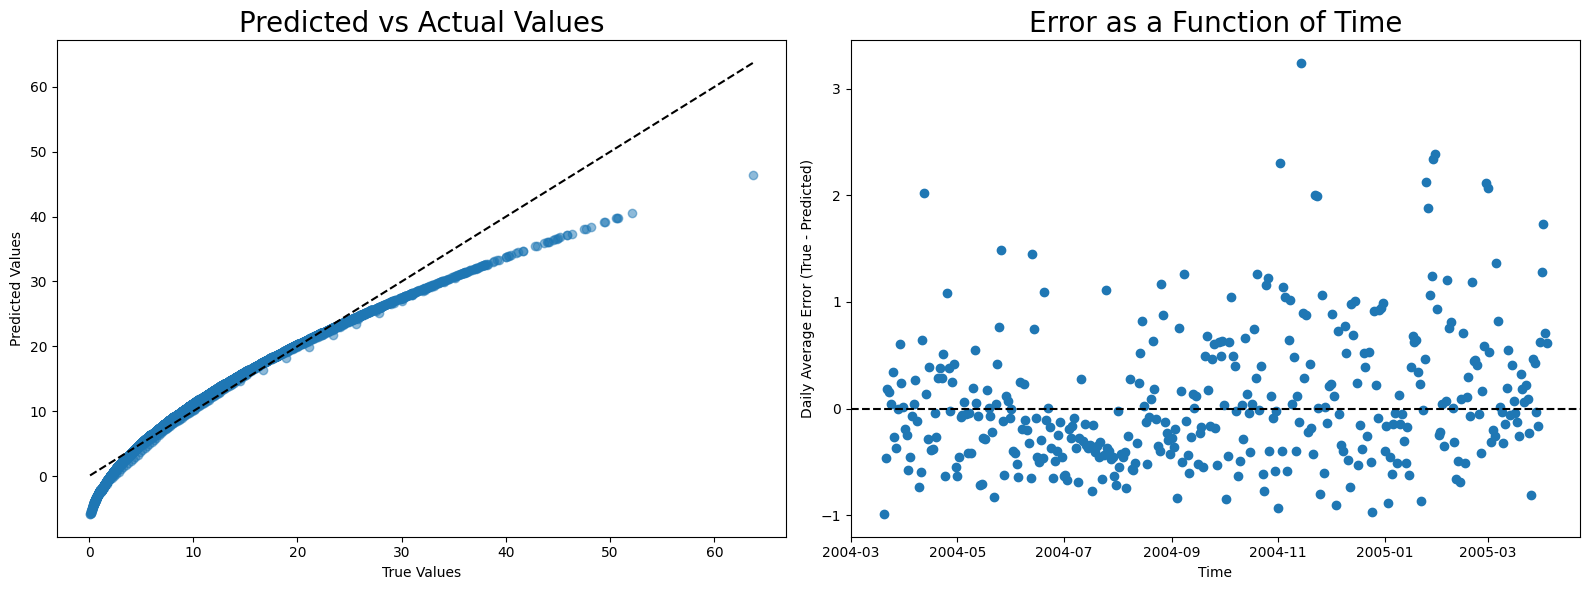

Mean Squared Error (MSE): 2.0636701896859755
Mean Absolute Error (MAE): 1.0612868870190344


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

def plot_and_evaluate(y_test, y_pred, time_index):
    """
    Plots predicted vs actual values and daily error, and calculates error metrics.
    
    Parameters:
    - y_test: True values
    - y_pred: Predicted values
    - time_index: Datetime index associated with y_test and y_pred
    
    Returns:
    - Prints MAE, MSE, MRE, STD_RE, and SCC.
    """
    # Calculate the error
    error = y_test - y_pred

    # Convert error to a pandas Series
    error_series = pd.Series(error, index=time_index)

    # Aggregate error by day
    daily_error = error_series.resample('D').mean()

    # Plotting the results and error as a function of time
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # First subplot: True vs Predicted values
    axs[0].scatter(y_test, y_pred, alpha=0.5)
    axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predicted Values')
    axs[0].set_title('Predicted vs Actual Values', fontsize=20)

    # Second subplot: Error as a function of time
    axs[1].plot(daily_error.index, daily_error, marker='o', linestyle='')
    axs[1].axhline(y=0, color='k', linestyle='--')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Daily Average Error (True - Predicted)')
    axs[1].set_title('Error as a Function of Time', fontsize=20)

    plt.tight_layout()
    plt.show()

    # Calculate Errors and Correlation
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Display the metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    
# Split the dataset into training and validation sets for C6H6 using PT08.S2
X_train = df.loc[df.index <= split_date, ['PT08.S2(NMHC)']]
y_train = df.loc[df.index <= split_date, 'C6H6(GT)']
X_test = df.loc[df.index > split_date, ['PT08.S2(NMHC)']]
y_test = df.loc[df.index > split_date, 'C6H6(GT)']

# Perform linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

### Polynomial Regression

Given linear regression's inadequacy for benzene readouts, a quadratic function provides a near-perfect fit. A simple quadratic regression, with a 10-day training period, effectively calibrates the 'PT08.S2(NMHC)' sensor for year-long benzene level monitoring.

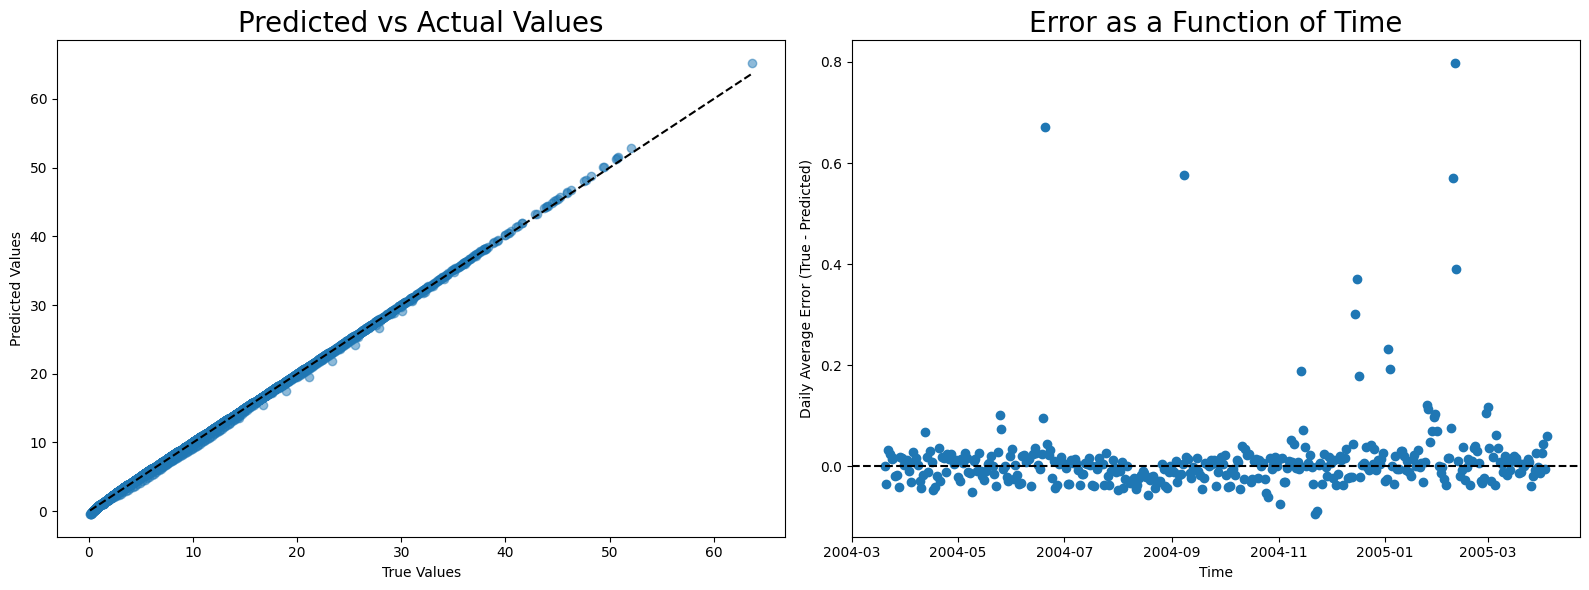

Mean Squared Error (MSE): 0.013792983307662095
Mean Absolute Error (MAE): 0.06464961653145739


In [17]:
from sklearn.preprocessing import PolynomialFeatures

# Transform the features into polynomial features.
degree = 2  # For example, using a quadratic polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Perform linear regression on the polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions
y_pred = model.predict(X_test_poly)

plot_and_evaluate(y_test, y_pred, y_test.index)

### Neural Network

While polynomial regression yields impressive results, the original study employed a 'sensor fusion' approach, which feeds all sensor data into a neural network model to provide the calibration. Replicating this approach, we observed a mean absolute error (MAE) of 0.52, significantly higher than the 0.06 achieved with polynomial regression, suggesting neural networks may not be a suitable choice given the dataset's size and feature count.

In [18]:
# Define a helper function
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

tf.random.set_seed(42)

def preprocess_and_train(df, target, features, epochs = 1000, learning_rate = 0.03, batch_size=128):
    # Splitting train, validation, and test sets
    first_split_date = df.index.min() + pd.Timedelta('10D')
    second_split_date = first_split_date + pd.Timedelta('10D')
    X_train = df.loc[df.index <= first_split_date, features]
    y_train = df.loc[df.index <= first_split_date, target]
    X_val = df.loc[(df.index > first_split_date) & (df.index <= second_split_date), features]
    y_val = df.loc[(df.index > first_split_date) & (df.index <= second_split_date), target]
    X_test = df.loc[df.index > second_split_date, features]
    y_test = df.loc[df.index > second_split_date, target]

    # Scaling the data
    scaler = StandardScaler()
    X_train_nn = scaler.fit_transform(X_train)
    X_val_nn = scaler.transform(X_val)
    X_test_nn = scaler.transform(X_test)

    # Neural network architecture
    model = Sequential([
        Dense(7, activation='tanh', input_shape=(X_train_nn.shape[1],)),
        Dense(3, activation='tanh'),
        Dense(5, activation='tanh'),
        Dense(15, activation='tanh'),
        Dense(20, activation='tanh'),
        Dense(1)
    ])
    # Use the legacy Adam optimizer
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Train the model
    history = model.fit(X_train_nn, y_train, validation_data=(X_val_nn, y_val), epochs=epochs, batch_size=batch_size, verbose=0)

    # Plot prediction results
    y_pred = model.predict(X_test_nn).flatten()
    plot_and_evaluate(y_test, y_pred, y_test.index)

    return model, history

def plot_training_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

2024-03-06 13:54:39.670743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 13:54:39.670935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 13:54:39.842590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


278/278 [==============================] - 0s 1ms/step


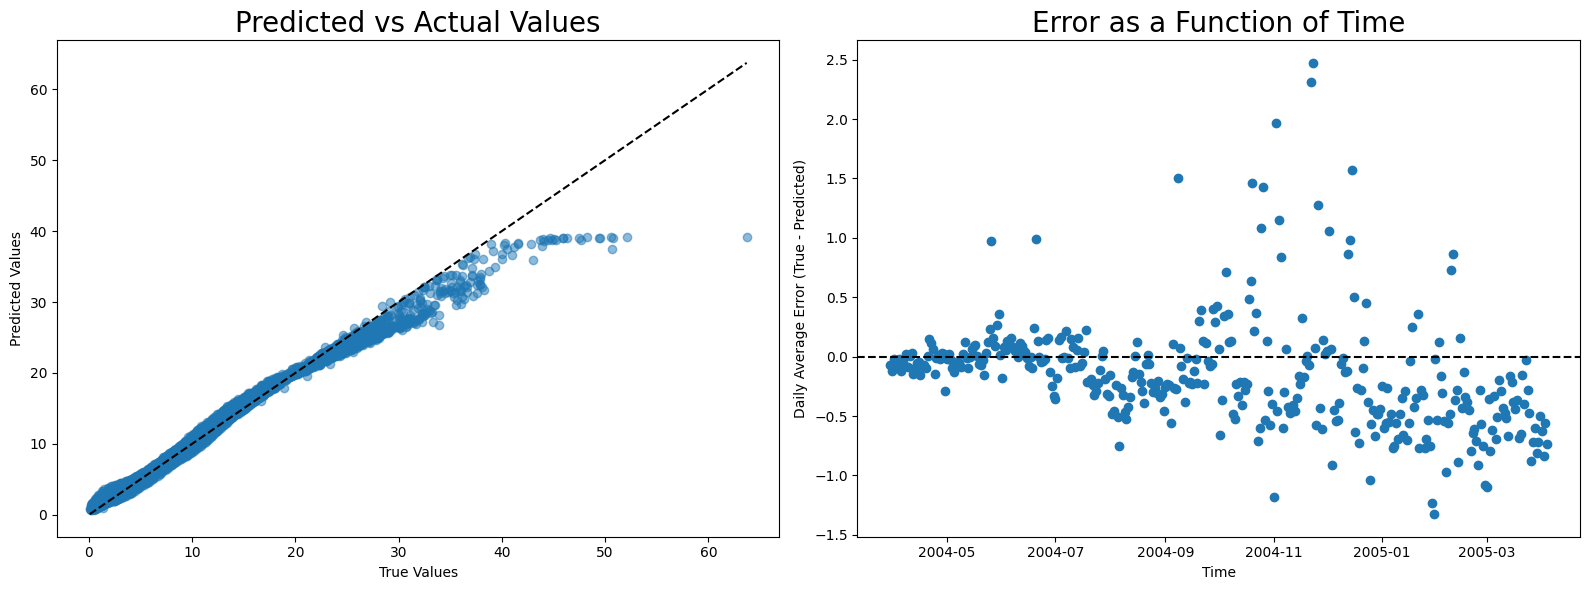

Mean Squared Error (MSE): 0.9171830709405588
Mean Absolute Error (MAE): 0.5595330569376877


In [19]:
# Define the targets and features
targets = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
target = targets[1]  # 'C6H6(GT)'
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

model, history= preprocess_and_train(df, target, features)
# plot_training_history(history)

### Random Forest

Trying moderately complex machine learning method, such as random forest, yields better performance than neural network, but is still no match compared to linear regression.

A brief summary of MAE scores:

- Linear regression: 0.06464961653145739
- Random Forest: 0.2284405194727994
- Neural network: 0.4388882121784993

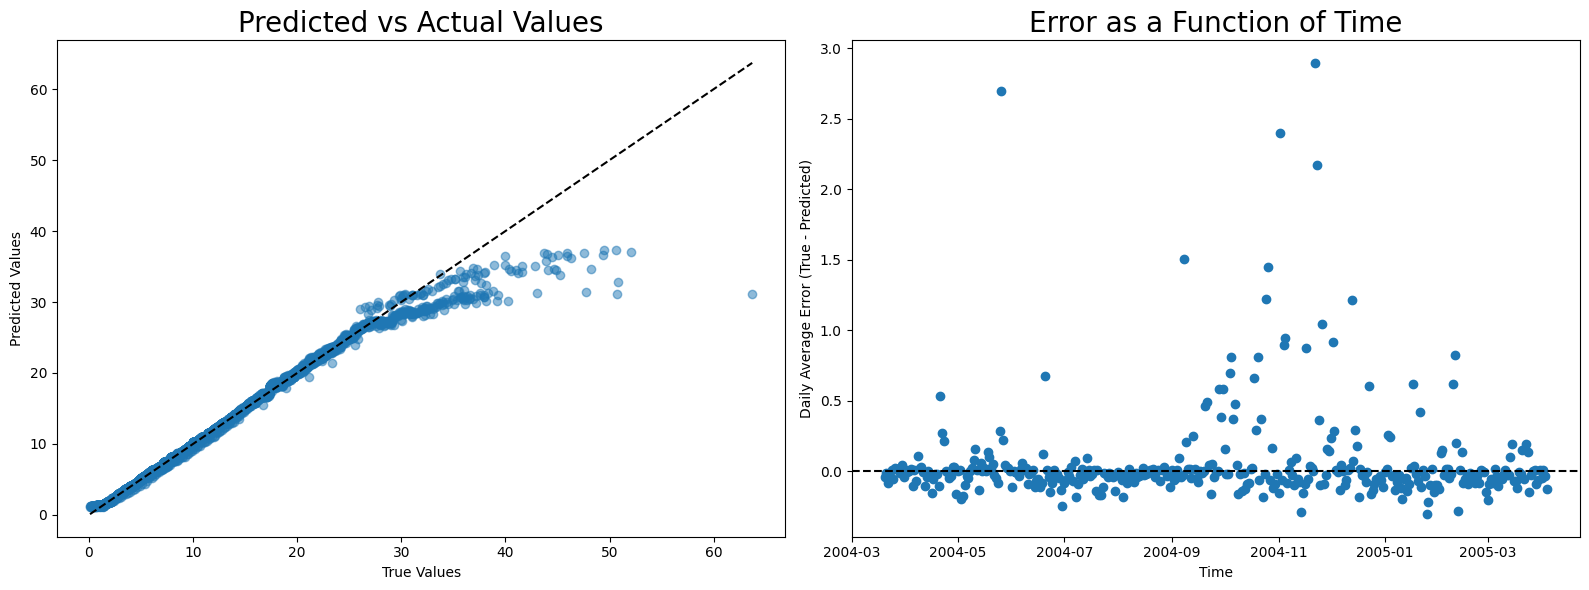

Mean Squared Error (MSE): 0.813765257626196
Mean Absolute Error (MAE): 0.2284405194727994


In [20]:
from sklearn.ensemble import RandomForestRegressor

# Define target
target = targets[1]  # 'C6H6(GT)'

# Splitting train, validation, and test sets
first_split_date = df.index.min() + pd.Timedelta('10D')
X_train = df.loc[df.index <= first_split_date, features]
y_train = df.loc[df.index <= first_split_date, target]
X_test = df.loc[df.index > first_split_date, features]
y_test = df.loc[df.index > first_split_date, target]

# Initialize and fit the TabularPredictor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

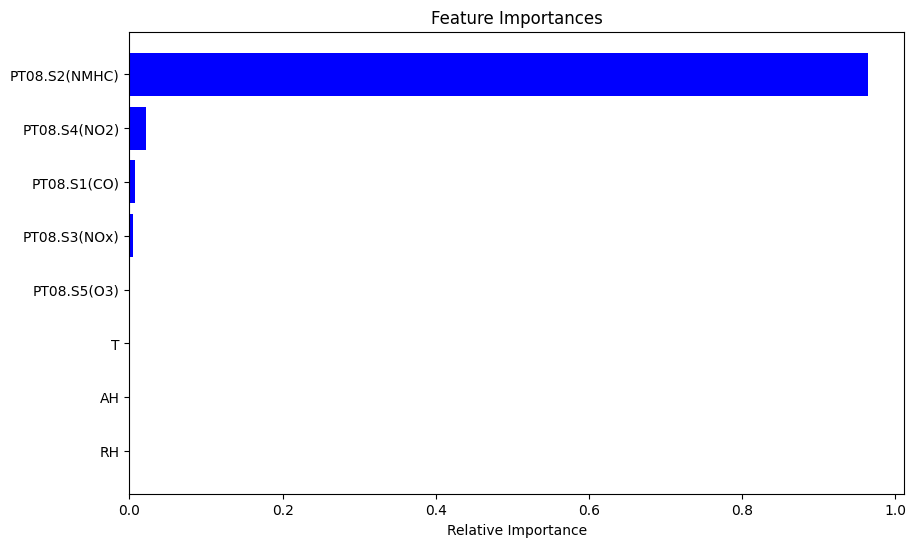

In [21]:
# Plotting the feature importance
feature_importances = rfr.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## CO

Calibration for CO concentration is much more difficult. With the same training time as the neural network, the random forest provides the best performance.

MAE scores

- Linear regression: 0.631317367890475
- Random Forest: 0.5451608378533798
- Neural network: 1.021655128654683

### Linear Regression

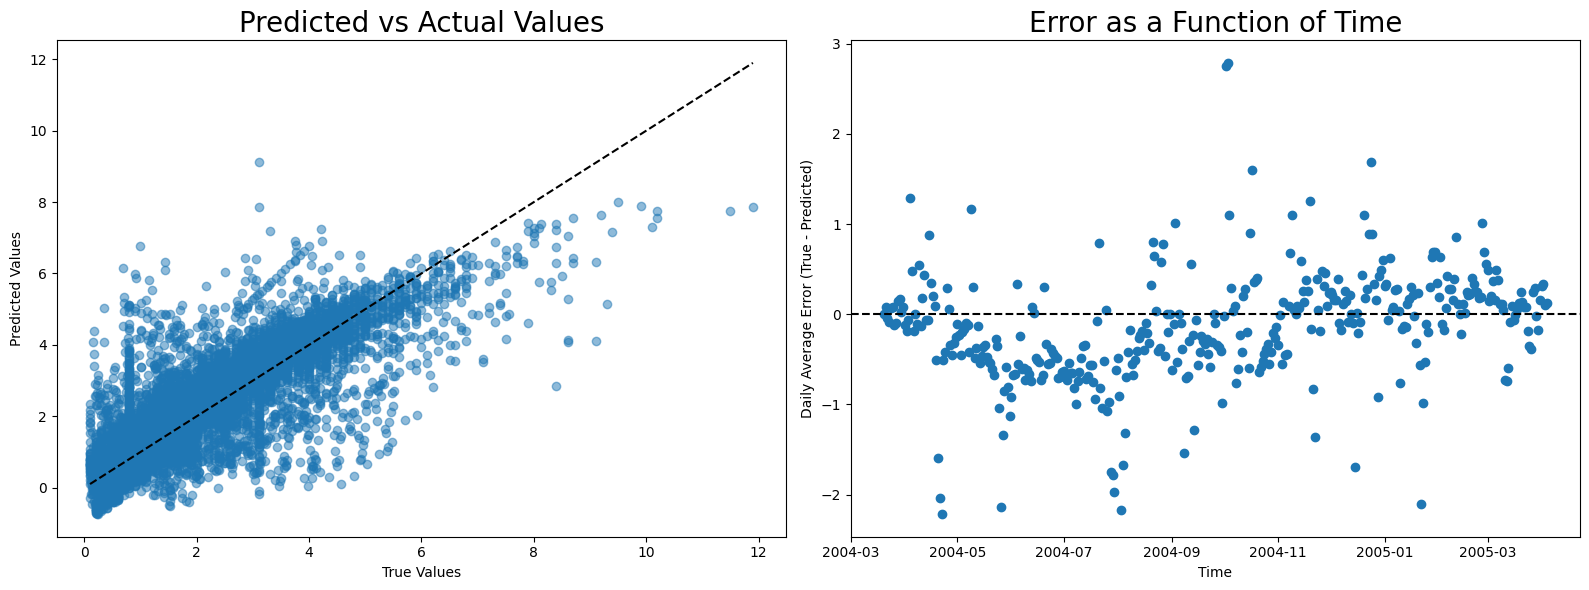

Mean Squared Error (MSE): 0.834207180734345
Mean Absolute Error (MAE): 0.631317367890475


In [22]:
target = targets[0]  # 'CO(GT)'

# Split the dataset into training and validation sets for C6H6 using PT08.S2
X_train = df.loc[df.index <= split_date, ['PT08.S2(NMHC)']]
y_train = df.loc[df.index <= split_date, target]
X_test = df.loc[df.index > split_date, ['PT08.S2(NMHC)']]
y_test = df.loc[df.index > split_date, target]

# Perform linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

### Random Forest

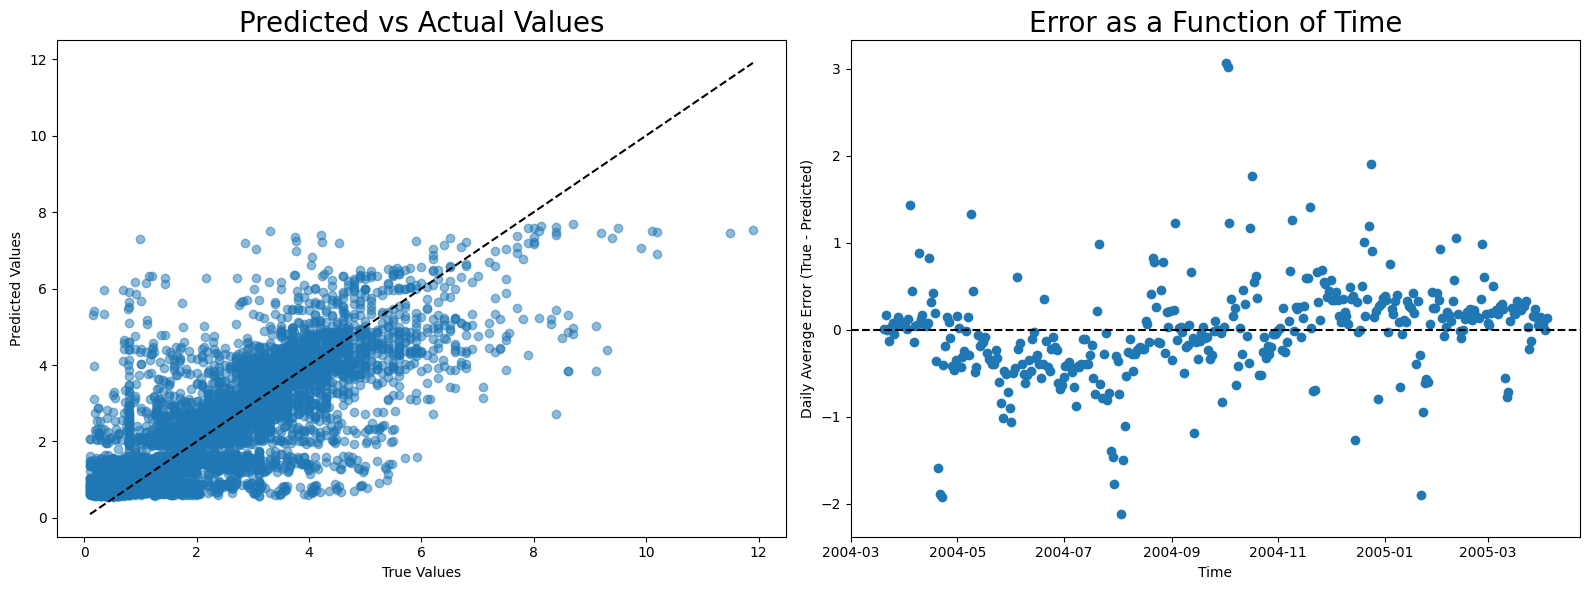

Mean Squared Error (MSE): 0.7581907258427731
Mean Absolute Error (MAE): 0.5451608378533798


In [23]:
# Splitting train, validation, and test sets
X_train = df.loc[df.index <= first_split_date, features]
y_train = df.loc[df.index <= first_split_date, target]
X_test = df.loc[df.index > first_split_date, features]
y_test = df.loc[df.index > first_split_date, target]

# Initialize and fit the TabularPredictor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

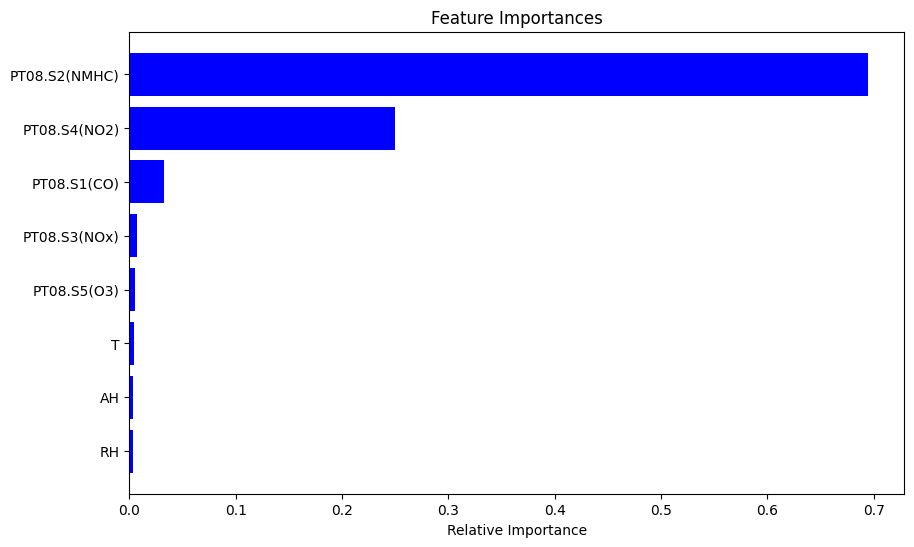

In [24]:
# Plotting the feature importance
feature_importances = rfr.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Neural Network

278/278 [==============================] - 0s 1ms/step


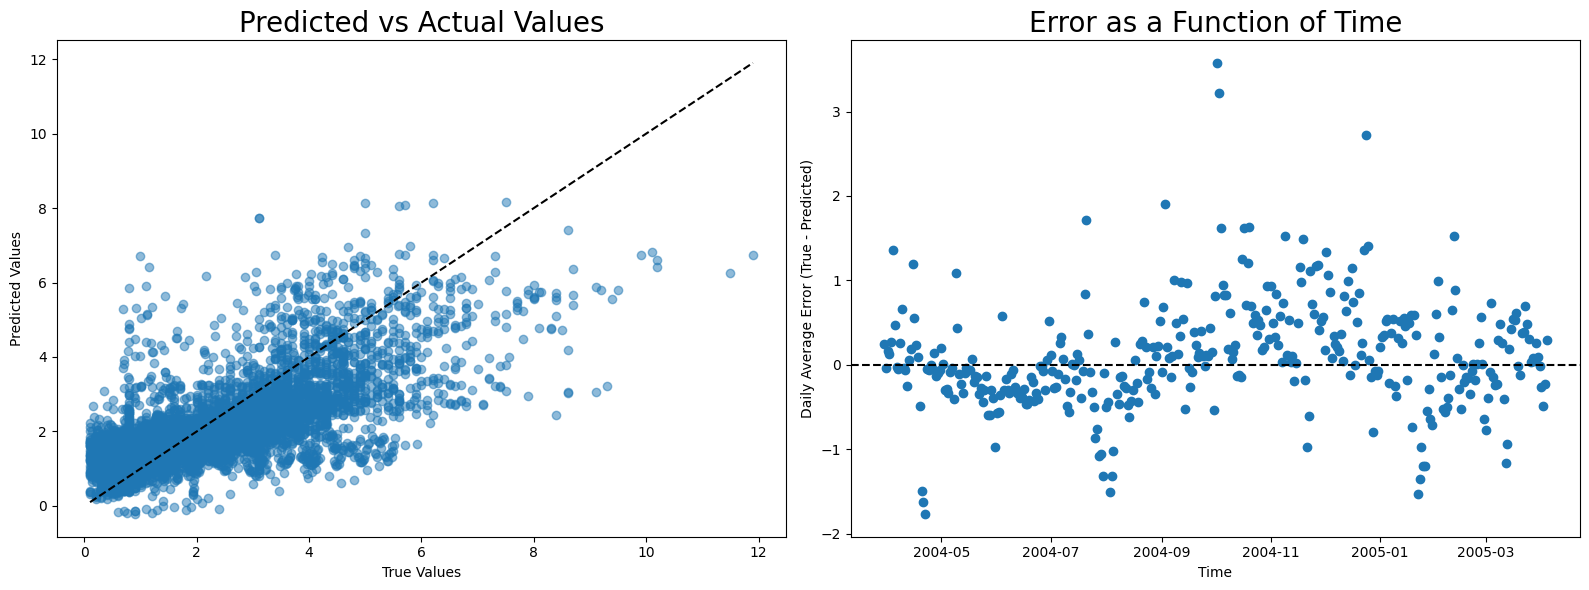

Mean Squared Error (MSE): 1.015032448442462
Mean Absolute Error (MAE): 0.7188524080441255


In [25]:
model, history= preprocess_and_train(df, target, features)
# plot_training_history(history)

## NOx

The calibration for NOx is even more difficult because of the sudden rise in NOx level after August. Notice that although linear regression has the best score, it has high error before and after August, while random forest and neural network have low error before August and high error after it, making them more appropriate compared to linear regression.

MAE scores

- Linear regression: 117.53067210253921
- Random forest: 131.48320603220608
- Neural network: 173.69570071251604

### Linear Regression

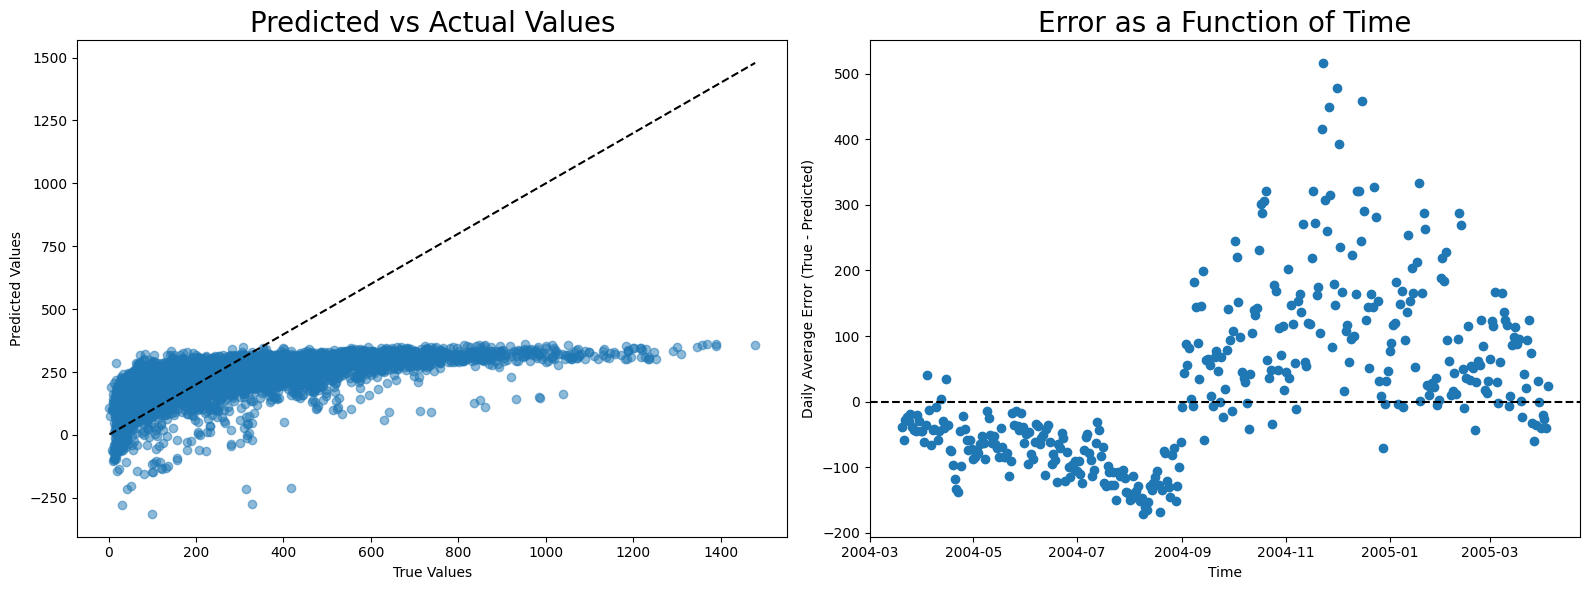

Mean Squared Error (MSE): 29805.192092710324
Mean Absolute Error (MAE): 117.53067210253921


In [26]:
target = targets[2]  # 'NOx(GT)'

# Split the dataset into training and validation sets for C6H6 using PT08.S2
X_train = df.loc[df.index <= split_date, ['PT08.S3(NOx)']]
y_train = df.loc[df.index <= split_date, target]
X_test = df.loc[df.index > split_date, ['PT08.S3(NOx)']]
y_test = df.loc[df.index > split_date, target]

# Perform linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

### Random Forest

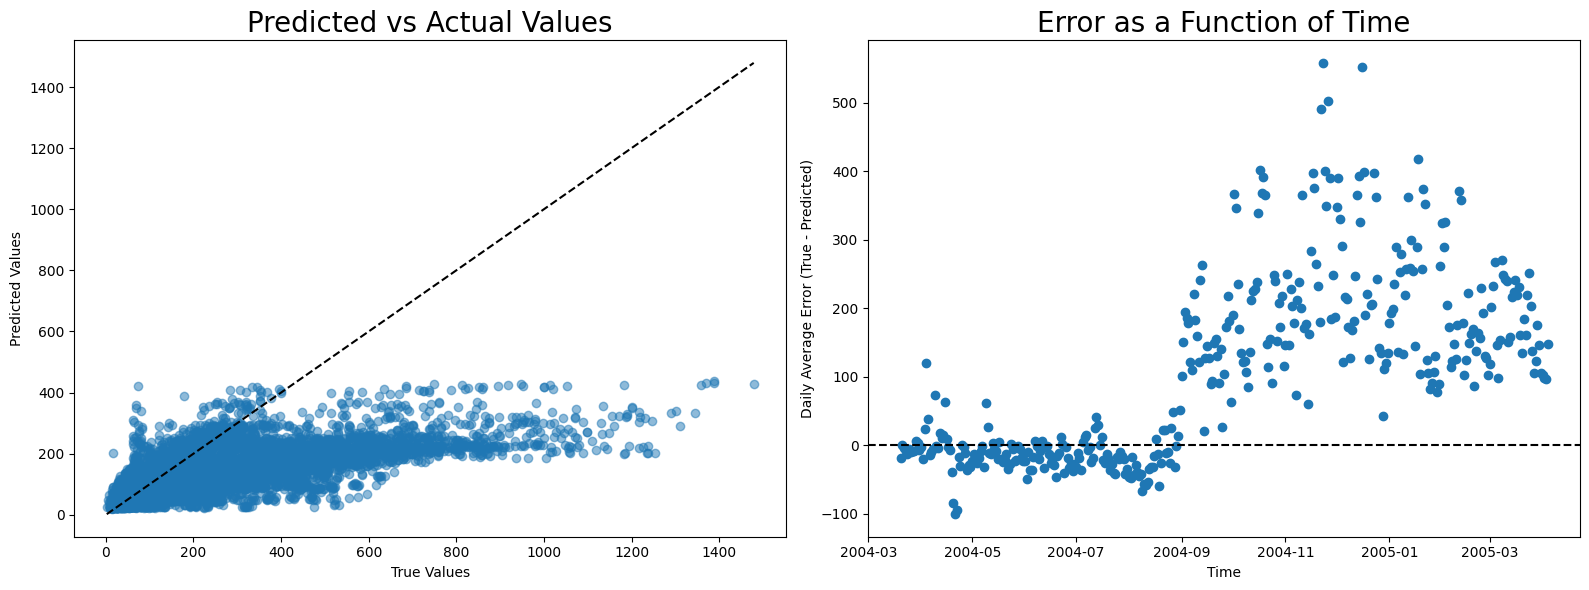

Mean Squared Error (MSE): 40502.669610667894
Mean Absolute Error (MAE): 131.48320603220608


In [27]:
# Splitting train, validation, and test sets
X_train = df.loc[df.index <= first_split_date, features]
y_train = df.loc[df.index <= first_split_date, target]
X_test = df.loc[df.index > first_split_date, features]
y_test = df.loc[df.index > first_split_date, target]

# Initialize and fit the TabularPredictor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

#### Feature Importance
Notice here the most important feature is absolute humidity, instead of any metal oxide sensor.

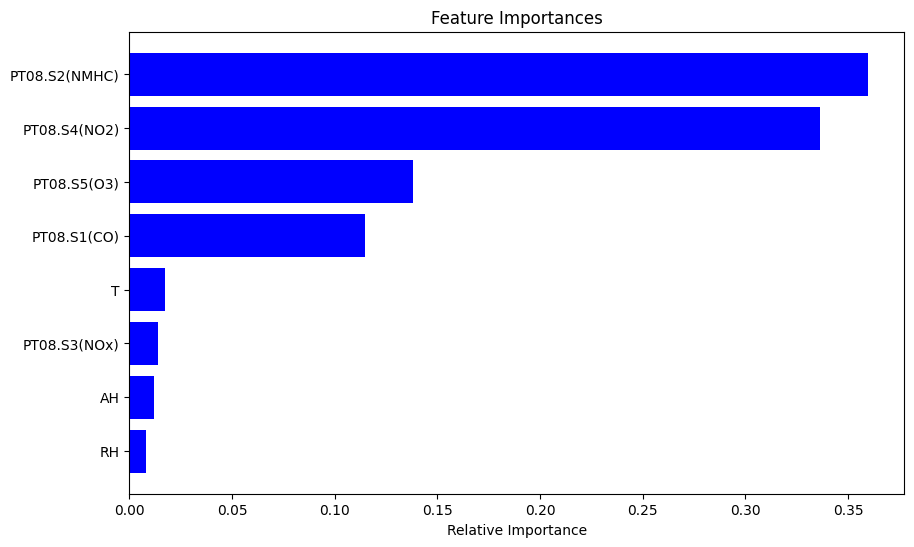

In [28]:
# Plotting the feature importance
feature_importances = rfr.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Neural Network

278/278 [==============================] - 0s 1ms/step


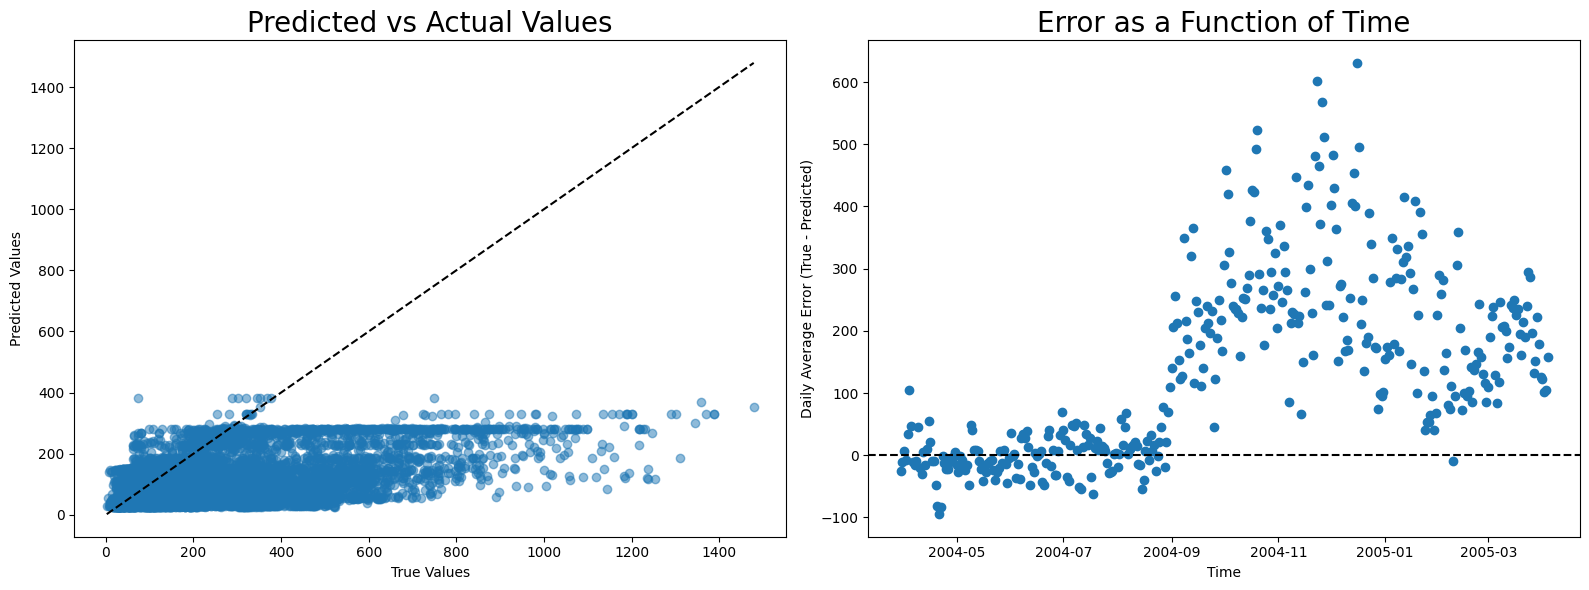

Mean Squared Error (MSE): 53435.27796294893
Mean Absolute Error (MAE): 155.6769154110217


In [29]:
model, history= preprocess_and_train(df, target, features, learning_rate=0.02, batch_size=32)
# plot_training_history(history)

## NO2

The calibration for NO2 also exhibits two periods: the first period gives reasonable fitting while the second period leads to a sudden rise in error. Here, linear regression is still the best calibration model.

MAE scores

- Linear regression: 27.22671494222509
- Random Forest: 28.167480404958546
- Neural network: 35.027760191767776

### Linear Regression

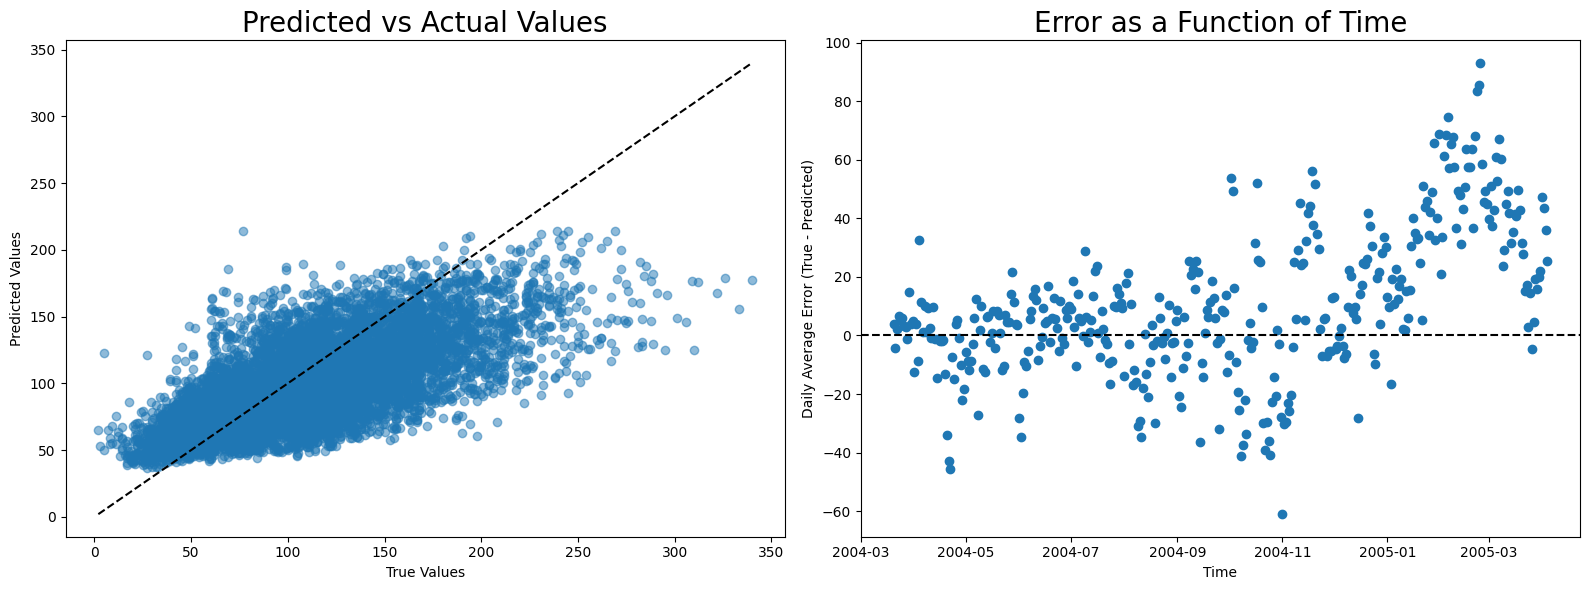

Mean Squared Error (MSE): 1293.1540647124516
Mean Absolute Error (MAE): 27.22671494222509


In [30]:
target = targets[3]  # 'NO2(GT)'

# Split the dataset into training and validation sets for C6H6 using PT08.S2
X_train = df.loc[df.index <= split_date, ['PT08.S5(O3)']]
y_train = df.loc[df.index <= split_date, target]
X_test = df.loc[df.index > split_date, ['PT08.S5(O3)']]
y_test = df.loc[df.index > split_date, target]

# Perform linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

### Random Forest

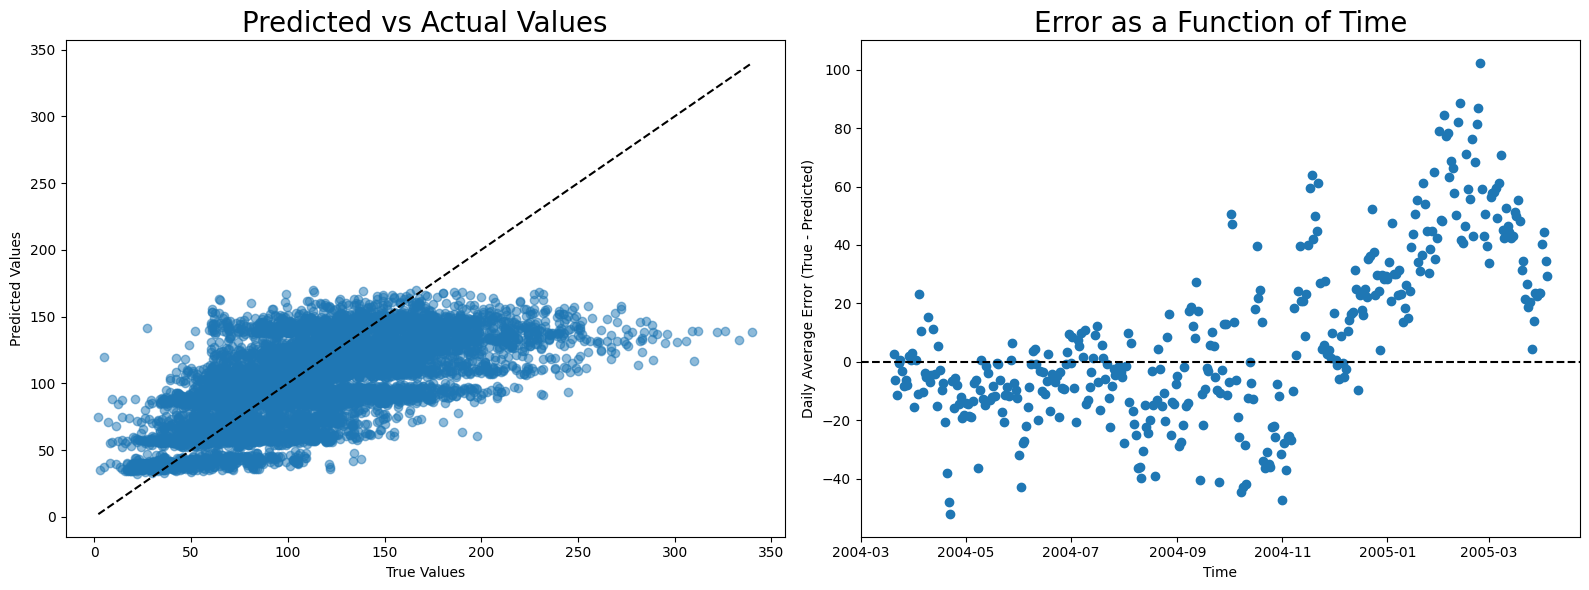

Mean Squared Error (MSE): 1407.705050765945
Mean Absolute Error (MAE): 28.167480404958546


In [31]:
# Splitting train, validation, and test sets
X_train = df.loc[df.index <= first_split_date, features]
y_train = df.loc[df.index <= first_split_date, target]
X_test = df.loc[df.index > first_split_date, features]
y_test = df.loc[df.index > first_split_date, target]

# Initialize and fit the TabularPredictor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr.predict(X_test)

plot_and_evaluate(y_test, y_pred, y_test.index)

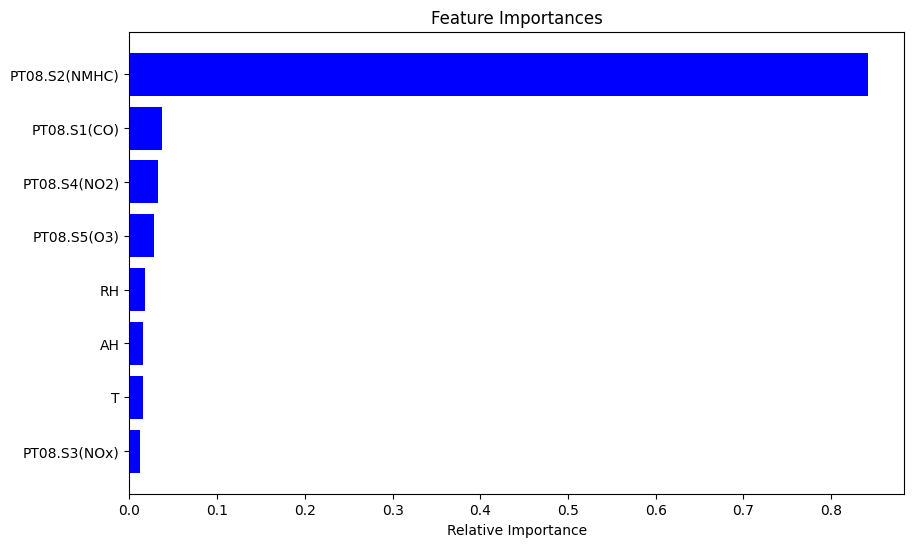

In [32]:
# Plotting the feature importance
feature_importances = rfr.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Neural Network

278/278 [==============================] - 0s 1ms/step


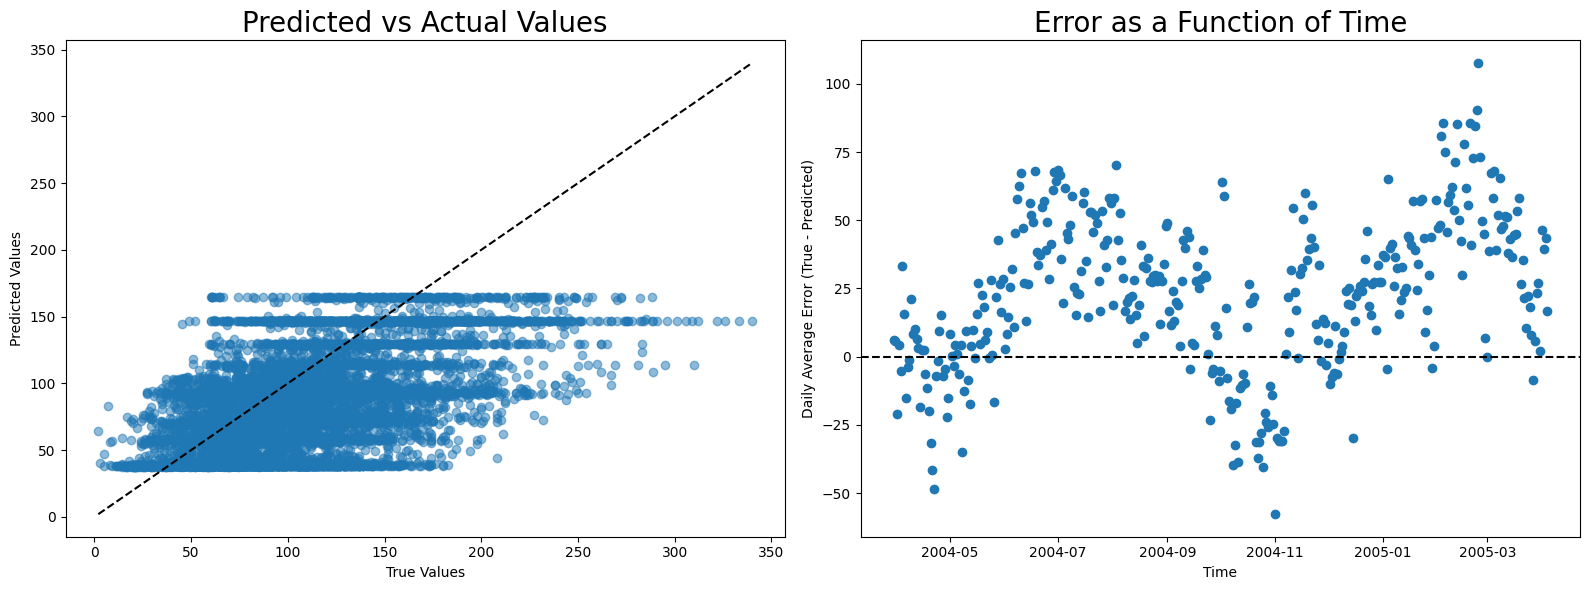

Mean Squared Error (MSE): 2174.307497571038
Mean Absolute Error (MAE): 36.46921322908441


In [33]:
model, history= preprocess_and_train(df, target, features, learning_rate=0.02, batch_size=32)
# plot_training_history(history)

## Conclusions

Developing low-cost, stable sensor arrays for air quality monitoring remains challenging. This analysis revealed that while the 'PT08.S2(NMHC)' sensor is notably stable and effective for benzene monitoring, the original paper's choice of neural network for sensor fusion calibration seems suboptimal. Linear regression and tree-based methods consistently outperformed neural networks in calibration accuracy. For enhanced calibration precision, multiple linear regression with regularization or fine-tuned ensemble tree-based methods are recommended.

Thank you for reading!